In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
import glob
import sys
import pickle
from scipy import interpolate ,optimize
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm_notebook as tqdm#from tqdm import tqdm
#look at fixing later 
import warnings
warnings.filterwarnings('ignore')

#import functions from file in path 
sys.path.insert(0, '/home/ben/Documents/Bonn-uni/internship/python_code/functions')
#from functions2 import MS_finder2
from data_loading import load_masses, load_models
#sys.path.insert(0, '/home/ben/Documents/Bonn-uni/internship/python_code/Interpolation')
from interpolation import M_V_T_interp, MVT_interp_setup, v_over_vcrit_interp

data_dir='/home/ben/Documents/Bonn-uni/internship/takeaway_data/' #'/users/bhastings/internship/data/MW/' # #

file_ext= '.dat2'

In [3]:

#load data in 
data_files, mass_list= load_masses(data_dir, 25)

data_df=load_models(data_files)

#for each mass, find initial velocity of fastest rotator
vmax_dict={}
for m in mass_list:
    di=data_df[data_df.M == m ]
    vmax=np.unique(di['V']).max()
    #print di['V_init'][di['V']== vmax].iloc[0], m
    vmax_dict[m]=di['V_init'][di['V']== vmax].iloc[0]

masses of models :
[ 3.  5.  7.  9. 10. 12. 15. 20. 25.]
working on file 112 / 112

# Interpolate V-M-T # 

In [4]:

v_T_interp= MVT_interp_setup(data_df, mass_list)
print M_V_T_interp(4,450, v_T_interp)

232340057.2630242


In [5]:
# find minimum initial velocities for star of mass m to be critical at sometime during MS

plot_df=pd.read_pickle('./plot_df.pk')
grouped = plot_df.groupby(['Be_value','M'])

vcritmin_dict={}

for g,group in grouped: 
    x=group['M']
    y=group['V_critmin'].min(skipna=True)
    #print g, y
    vcritmin_dict[g[0], g[1]]= y
    
#print vcritmin_dict



# Find initial values which are critical as a function of time  # 

In [ ]:
B_vals=tqdm([0.6,0.7,0.8,0.9,0.99])
v_crit_min_master={}
for B in B_vals:
    crit_rot_data={'B':B}
    for M in tqdm(np.flip(mass_list)):
        #message=str(B)+ '---'+ str(M)
        #sys.stdout.write ('\r'+ message)
        
        v_minM=vcritmin_dict[B,M] 
        if np.isnan(v_minM) ==True:
            
            continue 
        v_maxM=vmax_dict[M]
        v_minM=0.9*v_minM
        v_vals=tqdm(np.linspace(v_minM,v_maxM, 50))
        crit_times=map(lambda v: v_over_vcrit_interp(data_df,M, v, v_T_interp, False), v_vals)
        crit_rots_df=pd.DataFrame()
        for r in  crit_times:
            #first time star is faster than B
            crit_rotators=r[r['V/Vcrit']>B]

            if crit_rotators.empty == False:
                v_i=r['V_init'][0]
                t_1=r[r['V/Vcrit']>B]#.iloc[0]['t']
                #t_2=r[r['V/Vcrit']>B].iloc[-1]['t']
                #print 'V_i=',np.round(v_i,2),'t_1=' , np.round(t_1/1e6,3) , 't_2=', np.round( t_2/1e6,3)

                crit_rots_df=crit_rots_df.append(t_1)
                #crit_rots_df=crit_rots_df.append(pd.DataFrame([[M,v_i,t_1,t_2]], 
                #                                       columns=['M','V_init', 't1', 't2']))

        crit_rots_df.reset_index(drop=True, inplace=True)
        crit_rot_data[M]= crit_rots_df
        v_crit_min_master[B]= crit_rot_data
        
        #plt.plot( crit_rots_df['t']/1e6,crit_rots_df['V_init'], 'o')
        #plt.plot( crit_rots_df['t2']/1e6,crit_rots_df['V_init'], 'o')
        #plt.title(M)
        #plt.show()


#pickle.dump( v_crit_min_master, open( "crit_rot_data3.pk", "wb" ) )

In [7]:
v_crit_min_master= pickle.load(open('crit_rot_data2.pk', 'rb'))

# find boundaries of critical behaviour # 

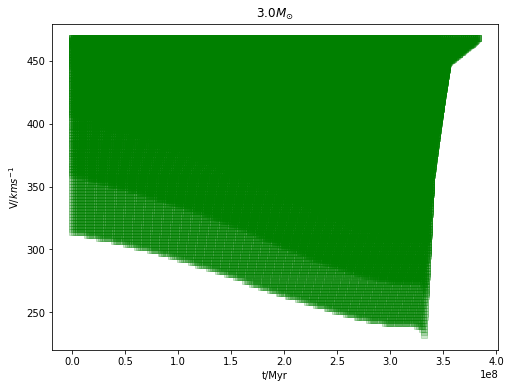

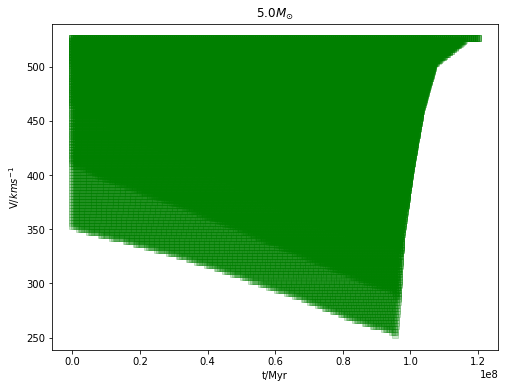

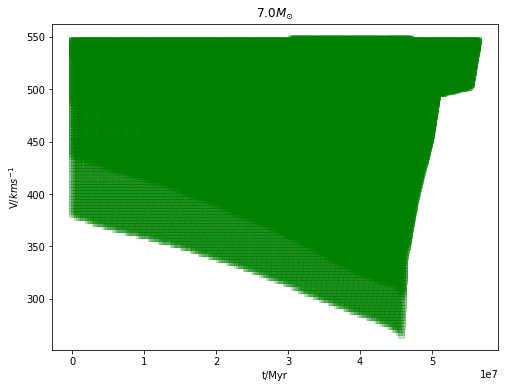

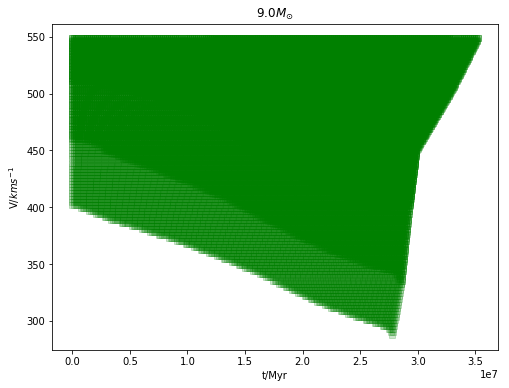

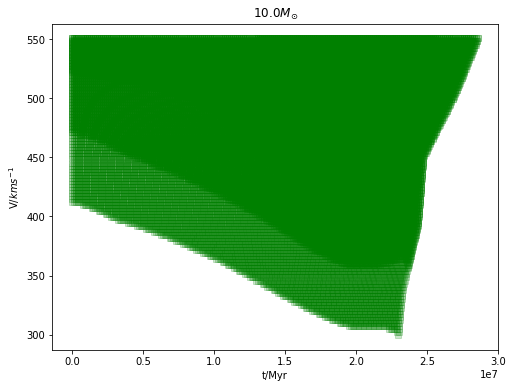

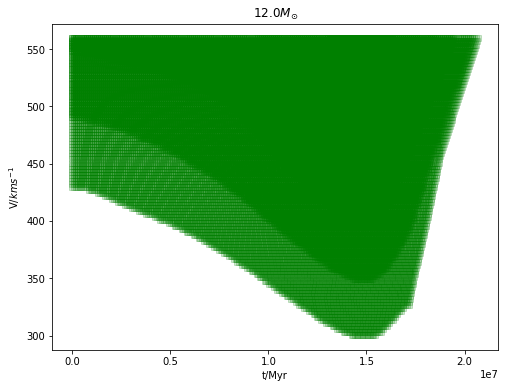

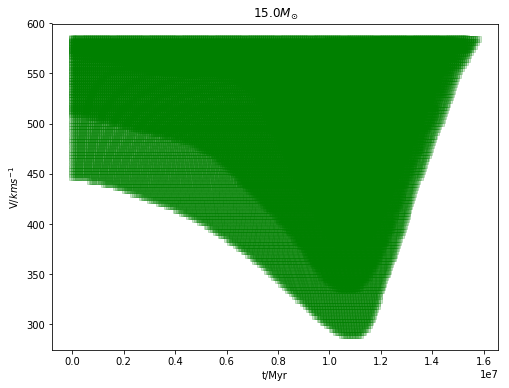

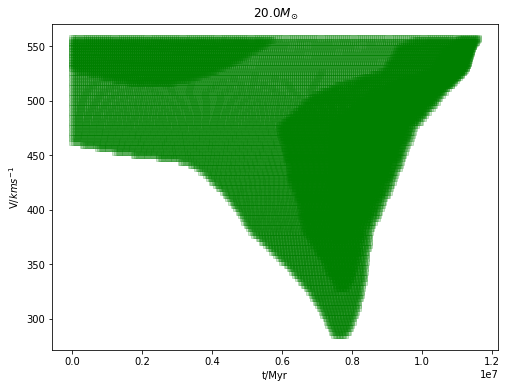

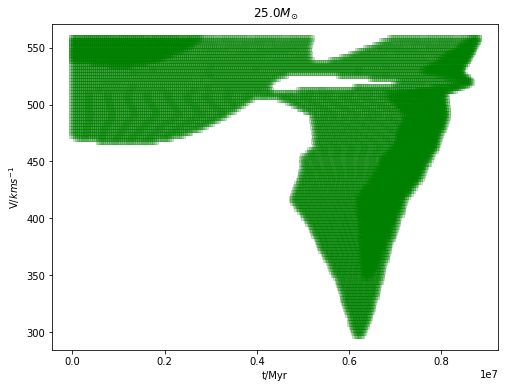

In [230]:
v_critmin_boundary={}
for M in ((mass_list)):#np.sort(v_crit_min_master[B].keys()):
    #plt.clf()
    for B in np.sort(v_crit_min_master.keys()):
        
        if M in v_crit_min_master[B]:
            crit_rots_df=v_crit_min_master[B][M]

        #else :
        #    continue
        #crit_rots_df= crit_rot_data[M]
            vcritmin_df=pd.DataFrame()
            for vi in np.unique(crit_rots_df['V_init']):
                di=crit_rots_df[crit_rots_df['V_init'] == vi ]
                di.reset_index(drop=True, inplace=True)
                x=di['t']
                y=di['V_init']
                T= di['t/T']
                ix=x.argmax()
                im= np.argmin(x)

                plt.plot(x, y, 'gs',alpha=0.2, label='_nolegend_')
                #plt.plot(x.loc[im], y.loc[im], 'g.')


                if np.isnan(ix) == False:
                    vcritmin_df=vcritmin_df.append(pd.DataFrame([[x.loc[ix],T.loc[ix], y.loc[ix]]], columns=['t','t/T', 'Vcrit_min']))
                if np.isnan(im) ==False :
                    vcritmin_df=vcritmin_df.append(pd.DataFrame([[x.loc[im], T.loc[im],y.loc[im]]], columns=['t','t/T', 'Vcrit_min']))


            vcritmin_df=vcritmin_df.sort_values(['t', 'Vcrit_min'], ascending=[True, False])

            v_critmin_boundary[B,M]= vcritmin_df

            x=vcritmin_df['t/T']
            y=vcritmin_df['Vcrit_min']
            #x,y=sort_into_line(x,y)
            #plt.fill_between( x/1e6, y,crit_rots_df['V_init'].max(), alpha=1, label=B)
            #plt.axvline(0)
            plt.plot(x,y, 'o-',label='_nolegend_' )
            plt.title(str(M) + str('$M_{\odot}$'))
            plt.legend(loc='lower left')
            plt.xlabel('t/Myr')
            plt.ylabel('V/$kms^{-1}$')
    plt.show()
    #plt.savefig(str(M)+'.png', dpi=300)
    
#pickle.dump(  v_critmin_boundary, open( "v_critmin_boundary.pk", "wb" ) )

[0.0, 0.0] [0.99, 0.99]


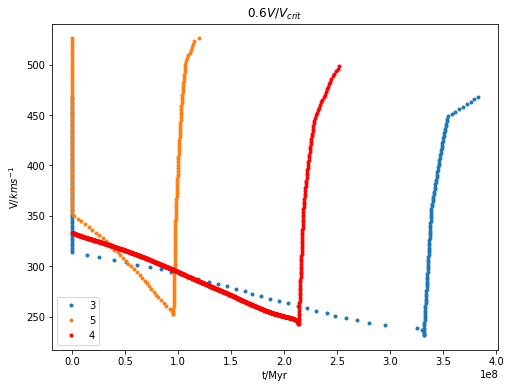

[0.0, 0.0] [0.99, 0.99]


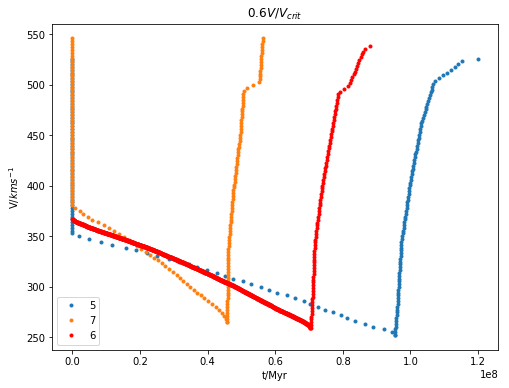

[0.0, 0.0] [0.99, 0.99]


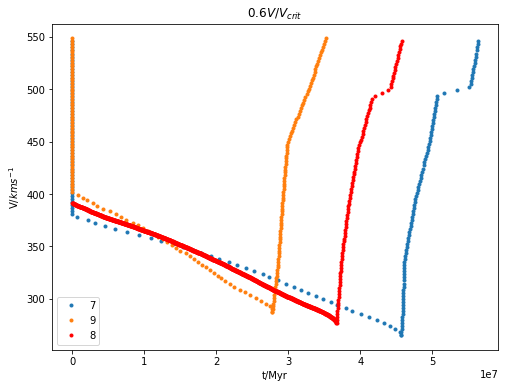

[0.0, 0.0] [0.99, 0.99]


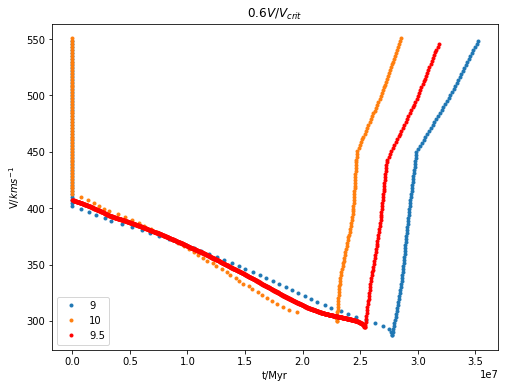

[0.0, 0.0] [0.99, 0.99]


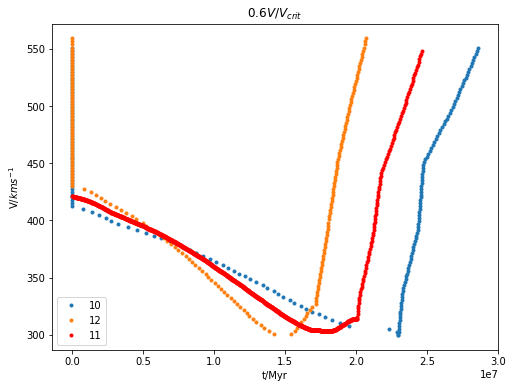

[0.0, 0.0] [0.99, 0.99]


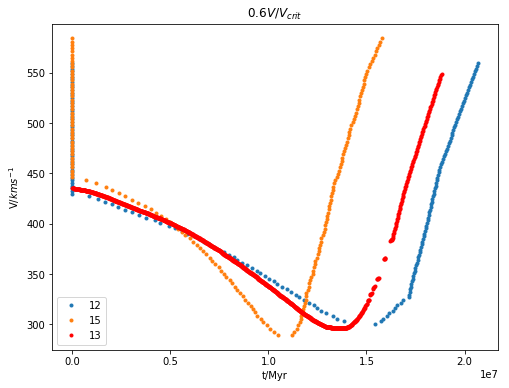

[0.0, 0.0] [0.99, 0.99]


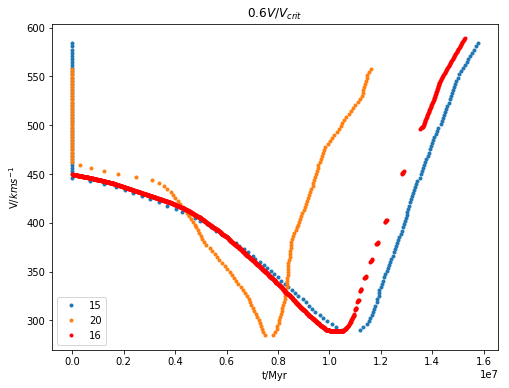

588.91025641 15264873.114879869


In [73]:
def interp_vcrit_min(m_i, B_i, data_df,v_critmin_boundary, vmax_dict ):
#m_i=5.6
#B_i=0.7
    plot=True
    m1= data_df[data_df['M'] <=  m_i].M.max()
    m2= data_df[data_df['M'] >  m_i].M.min()

    interp_lines={}
    plt.clf()
    for M in [m1,m2]:#np.sort(v_crit_min_master[B].keys()):
        
        for B in [B_i]:#np.sort(v_crit_min_master.keys()):
            #print v_critmin_boundary.keys(), B,M
            if (B,M) in v_critmin_boundary.keys():
                critmin_df=v_critmin_boundary[B,M]

            else :
                continue
            #crit_rots_df= crit_rot_data[M]

                #x=critmin_df['t/T']
                #y=critmin_df['Vcrit_min']

            x=critmin_df['t/T']#[(critmin_df['t/T'] < critmin_df['t/T'].max()) & 
                               #     (critmin_df['t/T'] > critmin_df['t/T'].min())]
            y=critmin_df['Vcrit_min']#[(critmin_df['t/T'] < critmin_df['t/T'].max()) & 
                                    #(critmin_df['t/T'] > critmin_df['t/T'].min())]

            straight_line=interpolate.interp1d(x,y,bounds_error=True, assume_sorted=True)

            interp_lines[M]= [straight_line, [x.min(),x.max()]]
            #print x.min(),x.max()
            #plt.plot(np.linspace(x.min(),x.max(),100), straight_line(np.linspace(x.min(),x.max(),100)))

            if plot:
                plt.plot(critmin_df['t'],critmin_df['Vcrit_min'], '.',label=M )
            

    a=interp_lines[m1]
    b=interp_lines[m2]
    mins=[a[1][0],b[1][0] ]
    maxs=[a[1][1],b[1][1] ]
    
    t_vals=np.linspace(max(mins), min(maxs), 1e3)

    a=interp_lines[m1][0]
    b=interp_lines[m2][0]
    res_df=pd.DataFrame()
    for t_i in t_vals:
        y=[a(t_i), b(t_i)]

        straight_line=interpolate.interp1d([m1,m2],y,bounds_error=True, assume_sorted=True)

        T= M_V_T_interp(m_i,straight_line(m_i), v_T_interp)

        res_df=res_df.append(pd.DataFrame([[t_i*T,straight_line(m_i), t_i]], columns=['t', 'V_init', 't/T']))


    res_df.reset_index(drop=True, inplace=True)
    # insert values with t/T =1 on leading edge of plot 
    
    res_df=res_df[:-1]

    v_vals=np.linspace(res_df['V_init'].iloc[res_df['t'].argmax()], vmax_dict[m1], 100)
    for v_i in v_vals: 
        T=M_V_T_interp(m_i,v_i, v_T_interp)

        res_df=res_df.append(pd.DataFrame([[0.99*T,v_i, 0.99]], columns=['t', 'V_init', 't/T']))

    res_df.reset_index(drop=True, inplace=True)
    if plot:
        plt.plot(res_df['t'],res_df['V_init'], 'r.' , label=m_i)
        plt.legend(loc='lower left')
        #plt.plot(x,y, '.',label=M )
        plt.title(str(B) + str('$V/V_{crit}$'))

        plt.xlabel('t/Myr')
        plt.ylabel('V/$kms^{-1}$')
        
        plt.show()

    return res_df

for m in [4,6,8,9.5,11,13,16]:
    res_df=interp_vcrit_min(m, 0.6, data_df,v_critmin_boundary, vmax_dict )

t=40e6

ik=(res_df['t']-t).abs().argmin()
print res_df['V_init'].iloc[ik],  res_df['t'].iloc[ik]

[0.6]
3.0 5.0 7.0 9.0 10.0 ['M', 'V_init', 't/T', 'V/Vcrit', 'V/Vcrit_init', 't']
12.0 ['M', 'V_init', 't/T', 'V/Vcrit', 'V/Vcrit_init', 't']
15.0 20.0 25.0

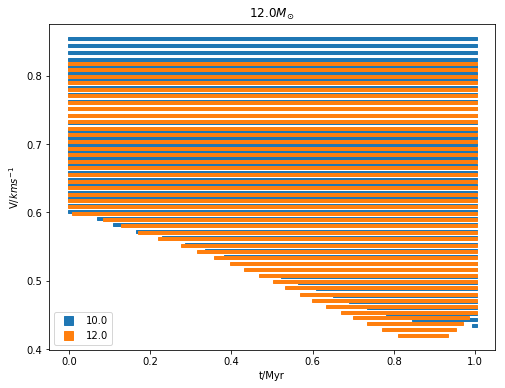

 DONE


In [67]:
print v_crit_min_master.keys()


for M in (mass_list):#np.sort(v_crit_min_master[B].keys()):
    print M,
    #plt.clf()
    plot_arr_df=pd.DataFrame()
    for B in np.sort(v_crit_min_master.keys()):
        
        if M in v_crit_min_master[B]:
            crit_rots_df=v_crit_min_master[B][M]

        else :
            continue
        #crit_rots_df= crit_rot_data[M]
        print crit_rots_df.columns.tolist()
        vcritmin_df=pd.DataFrame()
        #for vi in np.unique(crit_rots_df['V_init']):
        #    di=crit_rots_df[crit_rots_df['V_init'] == vi ]
        #    x=di['t']
        #    y=di['V_init']

            #ix=x.argmax()
            #im= x.argmin()

            
        
        #    for ti in np.unique(di['t']):
        #        plot_arr_df=plot_arr_df.append(di)
                
        x= crit_rots_df['t/T']#plot_arr_df['t']
        y= crit_rots_df['V/Vcrit_init']#plot_arr_df['V_init']
        maxT= x.max()
        plt.plot(x/maxT, y, 's', markersize=3, label=M)
       
        plt.title(str(M) + str('$M_{\odot}$') )#+'  $V/V_{crit}$ > '+ str(B))
        #plt.legend(loc='lower left')
        plt.xlabel('t/Myr')
        plt.ylabel('V/$kms^{-1}$')
        plt.legend(markerscale=3)
plt.show()
            #plt.savefig('./img/'+str(int(M))+'/'+str(int(M))+'-'+str(int(100*B))+'.png', dpi=300)
        #plt.savefig('./img/'+str(int(M))+'.png', dpi=300)
#plt.clf()
        
            
            
    #plt.savefig(str(M)+'.png', dpi=300)
    
print 'DONE'

[0.7, 0.9, 0.6, 0.8, 0.99]
[]
3.0

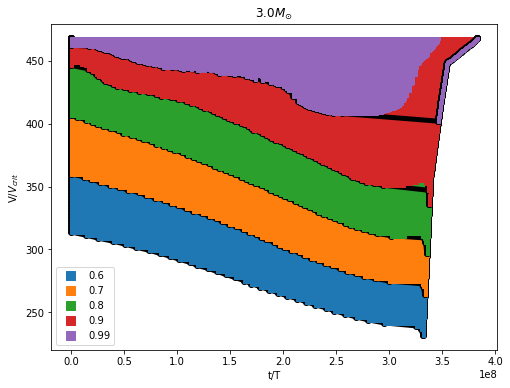

 5.0

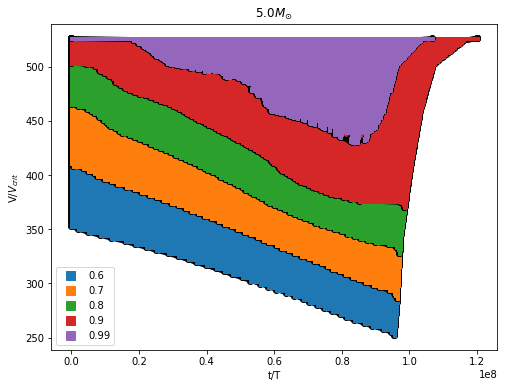

 7.0

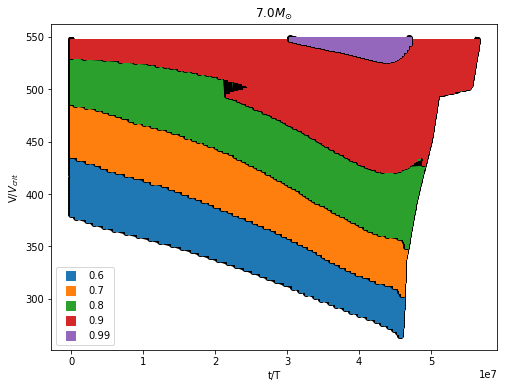

 9.0

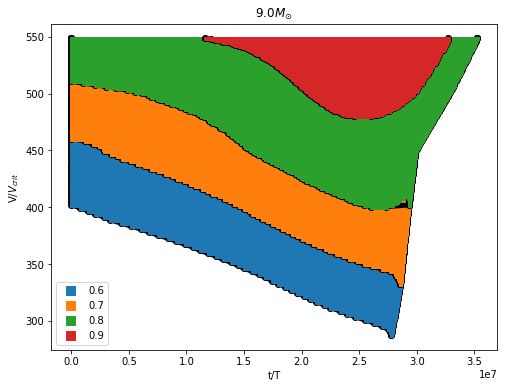

 10.0

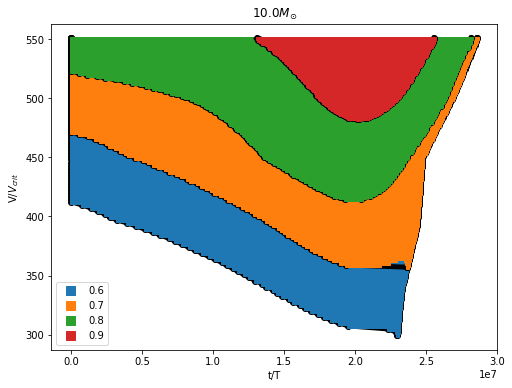

 12.0

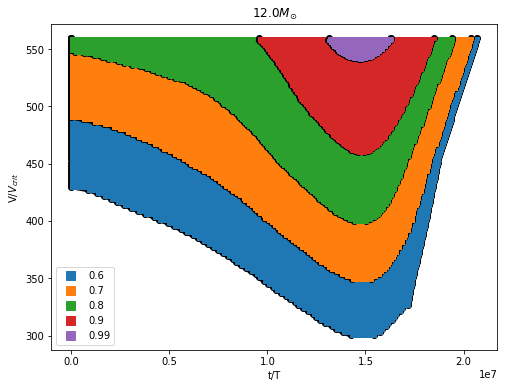

 15.0

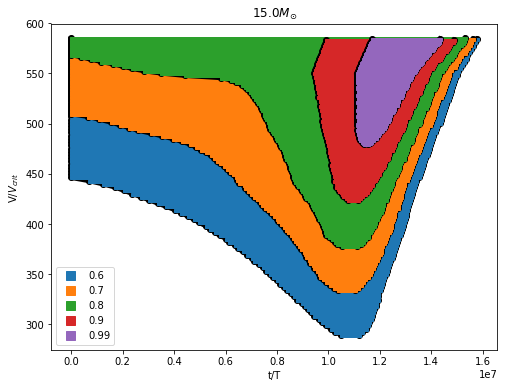

 20.0

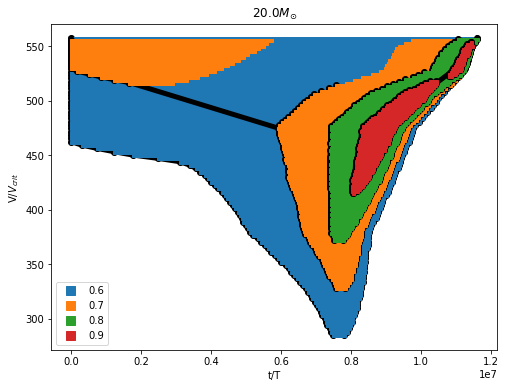

 25.0

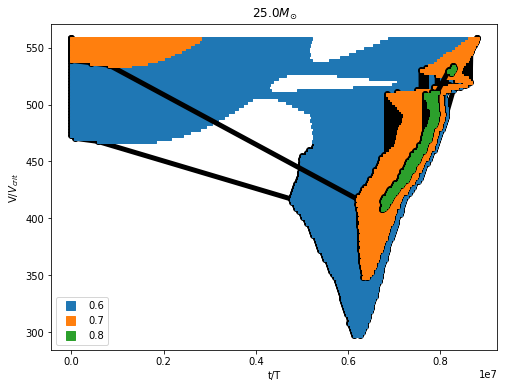

 [(0.9, 9.0), (0.8, 7.0), (0.7, 25.0), (0.99, 5.0), (0.7, 5.0), (0.6, 7.0), (0.8, 10.0), (0.6, 25.0), (0.7, 12.0), (0.9, 5.0), (0.8, 3.0), (0.8, 25.0), (0.9, 12.0), (0.8, 15.0), (0.6, 15.0), (0.9, 15.0), (0.7, 15.0), (0.8, 12.0), (0.99, 12.0), (0.8, 5.0), (0.99, 7.0), (0.9, 7.0), (0.6, 12.0), (0.99, 3.0), (0.7, 7.0), (0.6, 5.0), (0.8, 20.0), (0.9, 3.0), (0.99, 15.0), (0.9, 10.0), (0.7, 3.0), (0.6, 9.0), (0.7, 10.0), (0.8, 9.0), (0.6, 20.0), (0.7, 20.0), (0.6, 10.0), (0.9, 20.0), (0.7, 9.0), (0.6, 3.0)]
DONE


In [17]:
print v_crit_min_master.keys()

v_critmin_boundary={}
print v_critmin_boundary.keys()
for M in (mass_list):#np.sort(v_crit_min_master[B].keys()):
    print M,
    #plt.clf()
    plot_arr_df=pd.DataFrame()
    for B in np.sort(v_crit_min_master.keys()):
        
        if M in v_crit_min_master[B]:
            crit_rots_df=v_crit_min_master[B][M]

        else :
            continue
        #crit_rots_df= crit_rot_data[M]
        #print crit_rots_df.columns.tolist()
        vcritmin_df=pd.DataFrame()
        vcritmin_df=pd.DataFrame()
        for vi in np.unique(crit_rots_df['V_init']):
            di=crit_rots_df[crit_rots_df['V_init'] == vi ]
            di.reset_index(drop=True, inplace=True)
            x=di['t']
            y=di['V_init']
            T= di['t/T']
            ix=x.argmax()
            im= np.argmin(x)

            #plt.plot(x, y, 'gs',alpha=0.2, label='_nolegend_')
            #plt.plot(x.loc[im], y.loc[im], 'g.')


            if np.isnan(ix) == False:
                vcritmin_df=vcritmin_df.append(pd.DataFrame([[x.loc[ix],T.loc[ix], y.loc[ix]]], columns=['t','t/T', 'Vcrit_min']))
            if np.isnan(im) ==False :
                vcritmin_df=vcritmin_df.append(pd.DataFrame([[x.loc[im], T.loc[im],y.loc[im]]], columns=['t','t/T', 'Vcrit_min']))


        vcritmin_df=vcritmin_df.sort_values(['t', 'Vcrit_min'], ascending=[True, False])

        v_critmin_boundary[B,M]= vcritmin_df

        x=vcritmin_df['t']
        y=vcritmin_df['Vcrit_min']
        #x,y=sort_into_line(x,y)
        #plt.fill_between( x/1e6, y,crit_rots_df['V_init'].max(), alpha=1, label=B)
        #plt.axvline(0)
        plt.plot(x,y, 'ko-',label='_nolegend_', linewidth=5 )
        plt.title(str(M) + str('$M_{\odot}$'))
        plt.legend(loc='lower left')
        plt.xlabel('t/Myr')
        plt.ylabel('V/$kms^{-1}$')
    
        x= crit_rots_df['t']#plot_arr_df['t']
        y= crit_rots_df['V_init']#plot_arr_df['V_init']
        maxT= x.max()
        plt.plot(x, y, 's', markersize=3, label=B)
       
        plt.title(str(M) + str('$M_{\odot}$') )#+'  $V/V_{crit}$ > '+ str(B))
        #plt.legend(loc='lower left')
        plt.xlabel('t/T')
        plt.ylabel('V/$V_{crit}$')
        plt.legend(markerscale=3)
    plt.show()
            #plt.savefig('./img/'+str(int(M))+'/'+str(int(M))+'-'+str(int(100*B))+'.png', dpi=300)
        #plt.savefig('./img/'+str(int(M))+'.png', dpi=300)
#plt.clf()
        
            
            
    #plt.savefig(str(M)+'.png', dpi=300)
print v_critmin_boundary.keys()
print 'DONE'

In [ ]:
v_grid= np.unique(plot_arr_df['v'])
t_grid= np.linspace(0,np.unique(plot_arr_df['t']).max(), 10*len(np.unique(plot_arr_df['t'])))

for v in v_grid: 
    for t in t_grid: 
        dk= plot_arr_df[plot_arr_df== v]
        print (dk)#.abs().min()

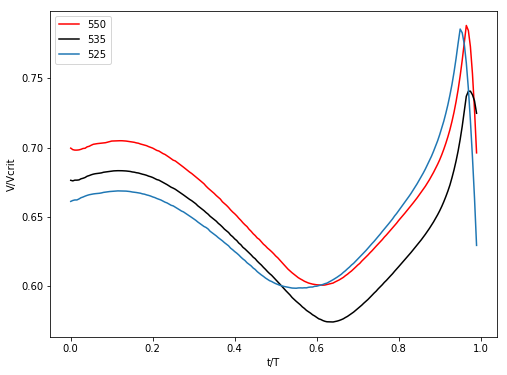

In [20]:
v_als=[550,535,525]

a=v_over_vcrit_interp(data_df,25, v_als[0], v_T_interp, False) #12M initially at v/vcrit=0.5
b=v_over_vcrit_interp(data_df,25, v_als[1], v_T_interp, False) # initially at v/vcrit=0.5
c=v_over_vcrit_interp(data_df,25, v_als[2], v_T_interp, False)# initially at v/vcrit=0.5

plt.plot( a['t/T'],a['V/Vcrit'], 'r-', label=v_als[0])
plt.plot( b['t/T'],b['V/Vcrit'], 'k-', label=v_als[1])
plt.plot( c['t/T'],c['V/Vcrit'], label=v_als[2])
plt.legend()
plt.xlabel('t/T')
plt.ylabel('V/Vcrit')
plt.axhline(0.6)
plt.show()

In [27]:
plt.clf()
plt.plot( a['t/T'],a['V/Vcrit'], 'r-', label=v_als[0])
plt.plot( b['t/T'],b['V/Vcrit'], 'k-', label=v_als[1])
plt.plot( c['t/T'],c['V/Vcrit'], label=v_als[2])
plt.legend()
plt.title('Interpolated $V/V_{crit}$ curves for 25$ M_{\odot}$ models')
plt.xlabel('t/T')
plt.ylabel('V/Vcrit')
plt.axhline(0.6, linestyle='--', color='k')
#plt.show()
plt.savefig('25-curves.png', dpi=300)

In [ ]:
grouped = plot_df.groupby(['Be_value','M'])

plot2=pd.DataFrame()

for g,group in grouped: 
    y_vals=[]
    #print group
    x=group['M']
    y=group['V_critmin'].min(skipna=True)
    y_vals=y_vals.append(y)
    plot2=plot2.append(pd.DataFrame([[g[1], y, g[0]]], columns=['M', 'V_critmin', 'Be_value']))
    
#print plot_df
#print plot2
grouped = plot2.groupby(['Be_value'])
for g,group in grouped: 
    x=group.M
    y=group['V_critmin']
    
    plt.plot(x,y,'o-', label=g)
    
    
plt.xlabel(r'$M_{\odot}$')
plt.ylabel(r'$V_{init}/kms^{-1}$')
plt.title('Min. $V_{init}$ for $V/V_{crit}$ to reach certain value')

plt.legend()
#plt.savefig('V_crit-min_plot4.png', dpi=300)
plt.show()



In [ ]:

interp_vcrit= lambda x: v_crit_interpolation[x['M']](x['V_critmin'])
plot_df.reset_index(inplace=True)
for index, row in plot_df.iterrows():
    #print index
    #print v_crit_interpolation[row.M](row['V_critmin'])
    #row['Vcrit_init']= v_crit_interpolation[row.M](row['V_critmin'])
    plot_df.set_value(index,'Vcrit_init', v_crit_interpolation[row.M](row['V_critmin']))
    
print plot_df.to_string()

In [ ]:
grouped = plot_df.groupby(['Be_value','M'])

plot2=pd.DataFrame()

for g,group in grouped: 
    x=group['M']
    idx=group['V_critmin'].argmin(skipna=True)
    if np.isfinite(idx):
        Vi=group['V_critmin'].loc[idx]
        Vc=group['Vcrit_init'].loc[idx]
        y=Vi/Vc
    else:
        y=np.nan
        
    plot2=plot2.append(pd.DataFrame([[g[1], y, g[0]]], columns=['M', 'V/V_critmin', 'Be_value']))

#print plot_df
#print plot2.to_string()
grouped = plot2.groupby(['Be_value'])
for g,group in grouped: 
    x=group.M
    y=group['V/V_critmin']
    
    plt.plot(x,y,'o-', label=g)
    
    
plt.xlabel(r'$M_{\odot}$')
plt.ylabel(r'$V/V_{crit}$')
plt.title('Min. initial critical fraction for $V/V_{crit}$ to reach certain value')

plt.legend()
#plt.savefig('V_crit-min_plot3.png', dpi=300)
plt.show()


In [ ]:
#print MS_finder2('/home/ben/Documents/Bonn-uni/internship/takeaway_data/f10-50.mw.dat2')
print data_df.columns.tolist()
plt.clf()
for m in np.unique(data_df.M):
    
    dx=data_df[data_df.M ==m]
    for vi in np.unique(dx['V_init'])[1::4]:
        dl=dx[(dx['V_init']==vi) & (dx['t/Tms'] <0.99)]
        x=dl['t/Tms']
        y=dl['2:M/Msun'] *dl['5:R/Rsun']**2 #  /dl['2:M/Msun'].iloc[0]
        plt.plot(x,y, label=str(int(vi)) +' km/s')
        plt.title(m)    
        
    #plt.ylim(0,1.05)
    plt.xlabel(r'$t/T_{MS}$')
    plt.ylabel(r'$I$')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),ncol=5)
    
    plt.savefig('/home/ben/Documents/Bonn-uni/internship/plots/I/'+str(m)+'.png', dpi=300,bbox_inches='tight')
    plt.show()
    plt.clf()